# Aestimo Tutorial #1

Aestimo is a python module for modelling a type of semiconductor heterostructure called a quantum well. These are structures made up of nanometre thick layers of semiconductors and we want to model how electrons behave within them which has to be done using quantum mechanics. So, this is a topic within condensed matter physics and the study of crystal bandstructure. Quantum wells are interesting because they expose the quantum mechanical nature of electrons in a way that we can engineer and they are also useful technologically to make diode lasers, photodetectors ... [1,2,3]

###Solvers
Aestimo currently contains a choice of solvers in order to model the quantum states. The solvers are both 1-dimensional self-consistant Poisson-Schrodinger solvers for finding the envelope wavefunctions and energy levels of bound states within quantum wells. A self-consistant Poisson-Schrodinger solution is one that finds the wavefunctions and charge distribution for a given potential and then updates the electric field part of the potential using the new solution before solving again; thus the algorithm iterates/converges towards a solution where the wavefunctions and the electronic potential are self-consistant.

Aestimo supports various types of semiconductors and arbitary quantum well designs. All the solvers take their parameters from the files `config.py`, `database.py` and an input file (`sample-*.py` files). The solvers can also be used as library modules as well as scripts.

This first solver is only useful for conduction band states and finds the wavefunctions using the shooting-wave method [1]. This solver can be dramatically sped up by compiling a cython module (see `setup_cython.py`)

+ `aestimo.py` is a conduction band Poisson-Schrodinger solver using the shooting-method. It can also account for the electron exchange interaction using an equation from Kohn-Sham density functional theory [4]. Additionally non-parabolicity of the in-plane dispersion curve can be modelled using an energy dependent effective mass, currently 2 models are implemented: Nelson's empirical 2-band model [4,5] and a k.p based model from Vurgaftman's 2001 paper [6]
  
The next solver finds solutions for both the conduction and valence bands

+ `aestimo_numpy_h.py` uses a finite-element model for both bands and a 3x3 k.p model for the valence band to account for mixing between the states. A k.p model is a more advanced model [1] than a quaisi-free electron model and can naturally account for nonparabolicity in each state's dispersion curves (although conduction band nonparabolicity is not currently accounted for since the conduction band is modelled separately from the valence band). This model also includes the effects of strain on the bandstructure. Since it uses a finite-element model, it behaves differently from the other solvers particularly for large grid sizes.
  
In this tutorial, we will find the wavefunctions of a simple structure using `aestimo.py`. For this notebook to work, we just need to make sure that aestimo exists somewhere on the PYTHONPATH.

Nb. In older versions of aestimo, `aestimo.py` was a different solver. It was a script rather than a library module (i.e. it ran immediately if imported) which made it less flexible to use. The current `aestimo.py` module corresponds to `aestimo_numpy2.py` in previous versions of aestimo. However, the original `aestimo.py` was deliberately kept simple in order to make it easier for someone to study how a simulation proceeds and it can still be found in the aestimo_elementary branch of the repository.

In [1]:
import os, sys

path = os.path.abspath("__file__" + "/../../")
print(path)

sys.path.append(path)

C:\Users\20141\OneDrive - purdue.edu\PhD_research\codes\LABcodes\aestimo-v.2.0-master\aestimo-master


In [2]:
#import aestimo.aestimo as solver

import aestimo as solver
import config as ac
import numpy as np
import matplotlib.pyplot as plt
import scipy

WARNING aestimo logs automatically to aestimo.log in the example's directory.
WARNING psi_at_inf_cython module not found


##`config.py`
Here we will explicity rewrite the `config.py` module in order to show the various options. The inputfilename parameter is used when the solvers are run directly or by `main.py` or `main_iterating.py`; however in this case we will be using the module directly. Most of the other parameters are self-explanatory, they either control various algorithm's parameters or where and what output should be saved.

In [3]:
# CONFIGURATION 

q = 1.602176e-19 #C
meV2J=1e-3*q #meV to Joules

# Input File(s)
# -------------
ac.inputfilename = "sample-qw-barrierdope"
#ac.inputfilename = "sample-qw-qwdope"
#ac.inputfilename = "sample-moddop"
#ac.inputfilename = "sample-qw-HarrisonCh3_3"
#ac.inputfilename = "sample-qw-barrierdope-p"
#ac.inputfilename = "sample-double-qw"

# Calculation
# -----------
# Aestimo / Aestimo_numpy
ac.use_cython = True #provides a speed up for aestimo and aestimo_numpy
# Shooting method parameters for Schrödinger Equation solution
ac.delta_E = 0.5*meV2J #Energy step (Joules) for initial search. Initial delta_E is 1 meV. 
ac.d_E = 1e-5*meV2J #Energy step (Joules) within Newton-Raphson method when improving the precision of the energy of a found level.
ac.E_start = 0.0    #Energy to start shooting method from (if E_start = 0.0 uses minimum of energy of bandstructure)
ac.Estate_convergence_test = 1e-9*meV2J
# FermiDirac
ac.FD_d_E = 1e-9 #Initial and minimum Energy step (meV) for derivative calculation for Newton-Raphson method to find E_F
ac.FD_convergence_test = 1e-6 #meV
ac.np_d_E = 1.0 # Energy step (meV) for dispersion calculations
# Poisson Loop
ac.damping = 0.5    #averaging factor between iterations to smooth convergence.
ac.max_iterations=80 #maximum number of iterations.
ac.convergence_test=1e-6 #convergence is reached when the ground state energy (meV) is stable to within this number between iterations.

# Aestimo_numpy_h
ac.strain = True # for aestimo_numpy_h
ac.piezo=True
#Set material type used in the structure 
ac.Wurtzite=True
ac.Zincblind=False

# Output Files
# ------------
ac.output_directory = "outputs"
ac.parameters = True
ac.electricfield_out = True
ac.potential_out = True
ac.sigma_out = True
ac.probability_out = True
ac.states_out = True

# Result Viewer
# -------------
ac.resultviewer = True
ac.wavefunction_scalefactor = 200 # scales wavefunctions when plotting QW diagrams
# Messages
# --------
ac.messagesoff = False
ac.logfile = 'aestimo.log'

In [15]:
#Here, we will alter the default settings of the config.py file for the purposes of this tutorial
ac.use_cython = False
ac.messagesoff = False

##`database.py`
At the moment, the database is very simple and consists only of dictionaries of parameters. Materials are described in the dict materialproperty and alloys are described in the dict alloyproperty.

In [16]:
import database as adatabase
from pprint import pprint

pprint(adatabase.materialproperty['GaAs'])

{'AVb_E': -6.92,
 'Ac': -7.17,
 'Av': 1.16,
 'B': -1.7,
 'BETAN': 2.0,
 'BETAP': 1.0,
 'Band_offset': 0.65,
 'C11': 11.879,
 'C12': 5.376,
 'Cn0': 2.8e-31,
 'Cp0': 2.8e-32,
 'Eg': 1.4223,
 'Ep': 28.8,
 'F': -1.94,
 'GA1': 6.8,
 'GA2': 1.9,
 'GA3': 2.73,
 'TAUN0': 1e-08,
 'TAUP0': 1e-08,
 'VSATN': 300000.0,
 'VSATP': 600000.0,
 'a0': 5.6533,
 'delta': 0.28,
 'epsilonStatic': 12.9,
 'm_e': 0.067,
 'm_e_alpha': 5.3782e+18,
 'm_hh': 0.45,
 'm_lh': 0.087,
 'mun0': 0.1,
 'mup0': 0.02}


##Modelling a Structure
We are going to model a simple barrier doped quantum well with AlGaAs for the barriers and GaAs for the well layer.

In [17]:
class Structure(object): pass
s = Structure() # this will be our datastructure

# TEMPERATURE
s.T = 60.0 #Kelvin

# COMPUTATIONAL SCHEME
# 0: Schrodinger
# 1: Schrodinger + nonparabolicity
# 2: Schrodinger-Poisson
# 3: Schrodinger-Poisson with nonparabolicity
# 4: Schrodinger-Exchange interaction
# 5: Schrodinger-Poisson + Exchange interaction
# 6: Schrodinger-Poisson + Exchange interaction with nonparabolicity
s.computation_scheme = 3

# Non-parabolic effective mass function
# 0: no energy dependence
# 1: Nelson's effective 2-band model
# 2: k.p model from Vurgaftman's 2001 paper
s.meff_method = 2

# Non-parabolic Dispersion Calculations for Fermi-Dirac
s.fermi_np_scheme = True #needed only for aestimo_numpy2.py

# QUANTUM
# Total subband number to be calculated for electrons
s.subnumber_e = 3
# Total subband number to be calculated for electrons (needed only for aestimo_numpy_h)
s.subnumber_h = 1 

# APPLIED ELECTRIC FIELD
s.Fapplied = 0.00/50e-9 # (V/m)

# --------------------------------
# REGIONAL SETTINGS FOR SIMULATION
# --------------------------------

# GRID
# For 1D, z-axis is choosen
s.gridfactor = 0.1 #nm
s.maxgridpoints = 200000 #for controlling the size

# REGIONS
# Region input is a two-dimensional list input.
# An example:
#         | Thickness (nm) | Material | Alloy fraction | Doping(cm^-3) | n or p type |
# Layer 0 |      250.0     |   Si     |      0         |     1e16      |     n       |
# Layer 1 |      250.0     |   Si     |      0         |     1e16      |     p       |
#
s.material =[[ 10.0, 'AlGaAs', 0.3, 0.0, 'n'],
            [ 5.0, 'AlGaAs', 0.3, 5e17, 'n'],
            [ 5.0, 'AlGaAs', 0.3, 0.0, 'n'],
            [ 11.0, 'GaAs', 0, 0, 'n'],
            [ 5.0, 'AlGaAs', 0.3, 0.0, 'n'],
            [ 5.0, 'AlGaAs', 0.3, 5e17, 'n'],
            [ 10.0, 'AlGaAs', 0.3, 0.0, 'n']]

# s.material =[[ 10.0, 'GaAs', 0, 0.0, 'n'],
#             [ 5.0, 'GaAs', 0, 0.0, 'n'],
#             [ 5.0, 'GaAs', 0, 0.0, 'n'],
#             [ 11.0, 'GaAs', 0, 0, 'n'],
#             [ 5.0, 'AlGaAs', 0.3, 0.0, 'n'],
#             [ 5.0, 'AlGaAs', 0.3, 5e17, 'n'],
#             [ 10.0, 'AlGaAs', 0.3, 0.0, 'n']]

INFO Total layer number: 7
INFO Total number of materials in database: 25
INFO Ntotal2d 5e+15 m**-2
INFO Iteration: 1
INFO Working for subband no: 1
INFO Working for subband no: 2
INFO Working for subband no: 3
INFO E[0]= 953.563384 meV
INFO E[1]= 1033.113477 meV
INFO E[2]= 1141.217991 meV
INFO meff[0]= 0.063139
INFO meff[1]= 0.067772
INFO meff[2]= 0.075118
INFO N[0]= 4.99999e+15 m**-2
INFO N[1]= 1.13016e+10 m**-2
INFO N[2]= 6.43718 m**-2
INFO Efermi (at 60K) = 972.214 meV
INFO total donor charge = 5e+15 m**-2
INFO total level charge = 5e+15 m**-2
INFO total system charge = -35.2397 m**-2
INFO Iteration: 2
INFO Working for subband no: 1
INFO Working for subband no: 2
INFO Working for subband no: 3
INFO E[0]= 971.919689 meV
INFO E[1]= 1049.774184 meV
INFO E[2]= 1156.531140 meV
INFO meff[0]= 0.063148
INFO meff[1]= 0.067809
INFO meff[2]= 0.075381
INFO N[0]= 4.99998e+15 m**-2
INFO N[1]= 1.50769e+10 m**-2
INFO N[2]= 11.1567 m**-2
INFO Efermi (at 60K) = 990.299 meV
INFO total donor charge = 

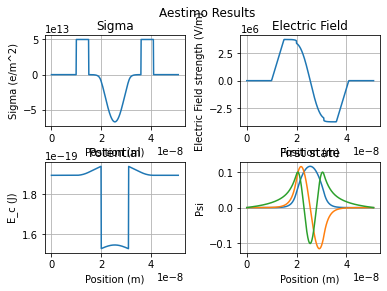

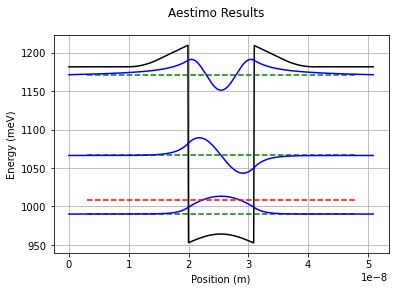

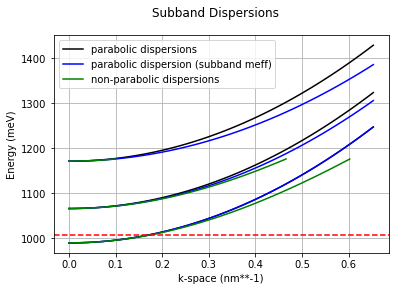

INFO Simulation is finished.


<Figure size 432x288 with 0 Axes>

In [18]:
# Initialise structure class
structure = s
model = solver.StructureFrom(structure,adatabase) # structure could also be a dictionary.
    
#calculate QW states
result = solver.Poisson_Schrodinger(model)

# Write the simulation results in files
%matplotlib inline
solver.save_and_plot(result,model)
plt.tight_layout()
solver.logger.info("Simulation is finished.")

We can get the energy levels of the model from the results object

In [9]:
print( 'state, Energy, Population, effective mass')
print( '     ,meV    , cm**-1    , m_e**-1')
for num,E,N,meff in zip(range(result.subnumber_e),result.E_state,result.N_state,result.meff_state):
    print( '%5d %7g %11.3g, %7.3g' %(num,E,N,meff))

state, Energy, Population, effective mass
     ,meV    , cm**-1    , m_e**-1
    0 990.152       5e+15, 5.75e-32
    1 1066.35       2e+10, 6.18e-32
    2 1171.36        20.8, 6.91e-32


1. Paul Harrison, *Quantum Wells, Wires and Dots*, 3rd. Ed. (Wiley, 2010).
2. John Singleton, *Band Theory and Electronic Properties of Solids*, 1st Ed. (Oxford University Press, 2001).
3. Mark Fox, *Optical Properties of Solids*, 2nd Ed. (Oxford University Press, 2010).
4. Manfred Manfred, *Intersubband Transitions in Quantum Wells: Physics and Device Applications I.*, Ch.1, edited by H.C.Liu and F. Capasso. (Academic Press, Semiconductors and Semimetals Series, 2000).
5. D.F. Nelson et al., Phys. Rev. B **35**, 7770 (1987)
6. I. Vurgaftman, J.R. Meyer, JR, L.R. Ram-Mohan, *Band parameters for III–V compound semiconductors and their alloys*, Journal of applied physics, **89**(11), 5815–5875 (2001).